In [1]:
import time
import datetime
import pandas as pd
import numpy as np
import typing as tp
import re
import matplotlib.pyplot as plt
import folium
import requests
import os
import gc
import seaborn as sns
import MiniP as mp
#
# 사용할 한글 폰트 설정 및 적용
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
#
# 최적화 함수 정의
def optimize_dataframe(df):
    # 숫자형 컬럼의 데이터 타입을 다운캐스팅
    for col in df.select_dtypes(include=['int']).columns:
        df[col] = pd.to_numeric(df[col], downcast='unsigned')
    for col in df.select_dtypes(include=['float']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    # 범주형 데이터로 변환
    for col in df.select_dtypes(include=['object']).columns:
        num_unique_values = len(df[col].unique())
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            df[col] = df[col].astype('category')
    return df

# 청크 단위로 데이터 로드 및 최적화
filename0 = r"data/big_df.csv"
chunk_size = 100000  # 청크 사이즈 설정
chunks = []

for chunk in pd.read_csv(filename0, chunksize=chunk_size):
    chunk_optimized = optimize_dataframe(chunk)
    chunks.append(chunk_optimized)
    # 메모리 해제를 위해 청크 삭제 및 가비지 컬렉션 수행
    del chunk, chunk_optimized
    gc.collect()

# 모든 청크를 결합
df_optimized = pd.concat(chunks, ignore_index=True)
big_df = df_optimized
big_df.drop(columns=['Unnamed: 0'], inplace=True)

big_df['StartDate'] = pd.to_datetime(big_df['StartDate'])

# 일별 요일 부여
big_df['WeekNum'] = big_df['StartDate'].apply(lambda x: x.weekday())

# 평일 주말 구분
big_df['Bi'] = big_df['WeekNum'].apply(lambda x: 'WeekDay' if x < 5 else 'WeekEnd')

big_df['StartTime'].fillna(0, inplace=True)
big_df['StartTime'] = big_df['StartTime'].astype(float).astype(int)

df_day_use = big_df.groupby('StartDate').agg({'UseTimeM':'sum','UseDistM':'sum'})
df_day_use['UseTimeM'] = (df_day_use['UseTimeM'] / 60).astype(int)
df_day_use.rename(columns={'UseTimeM':'UseTimeH'}, inplace=True)

C:\Users\human\AppData\Local\Temp\ipykernel_21672\2010610134.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  big_df['StartTime'].fillna(0, inplace=True)


Text(41.347222222222214, 0.5, '이동거리')

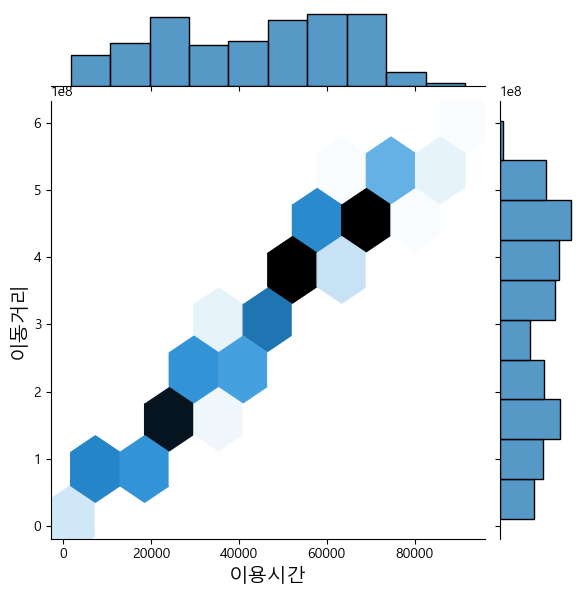

In [3]:
sns.jointplot(x='UseTimeH',y='UseDistM', data = df_day_use, kind='hex')
plt.xlabel('이용시간',fontsize=14)
plt.ylabel('이동거리',fontsize=14)

C:\Users\human\AppData\Local\Temp\ipykernel_21672\3960904907.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_age_group_time = big_df.groupby(['StartTime','Birth'])


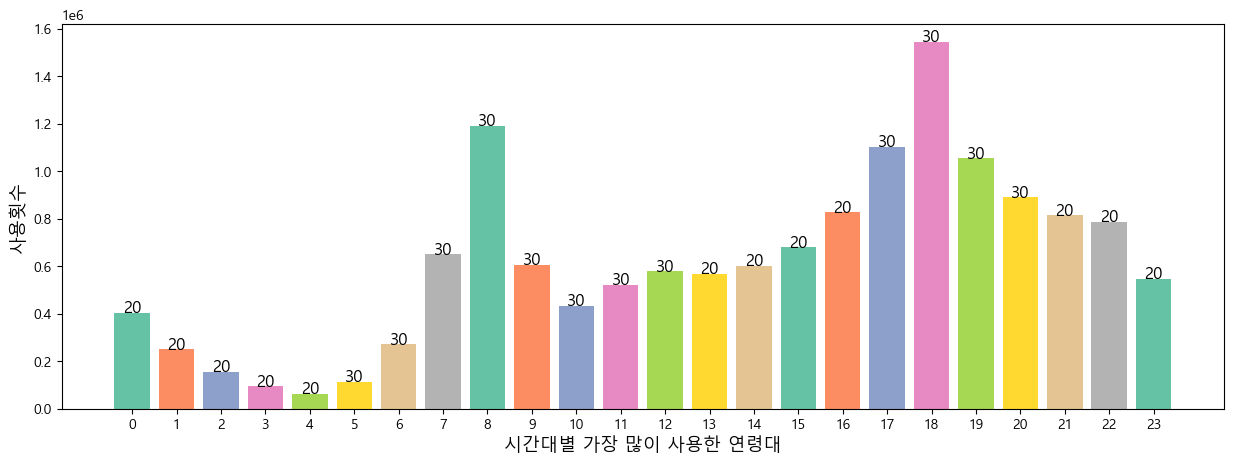

103

In [4]:
df_age_group_time = big_df.groupby(['StartTime','Birth'])
age_group_count=  df_age_group_time.size().unstack()
#
maxvalue = age_group_count.max(axis=1)
maxidx   = age_group_count.idxmax(axis=1)
df_use_age = pd.DataFrame(maxvalue, columns=['연령대'])
#
colors = sns.color_palette('Set2',15) 
plt.figure(figsize=(15, 5)) 
plt.xticks(range(0, 24, 1))
plt.xlabel('시간대별 가장 많이 사용한 연령대',fontsize=13)
plt.ylabel('사용횟수',fontsize=13)
bars_value = plt.bar(maxidx.index, df_use_age['연령대'], color=colors)
#
for bar , value in zip(bars_value,maxidx):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.3,value,
    fontsize=12,color='black',
    ha='center')
plt.show()

del df_age_group_time, age_group_count, maxvalue, maxidx, df_use_age
gc.collect()

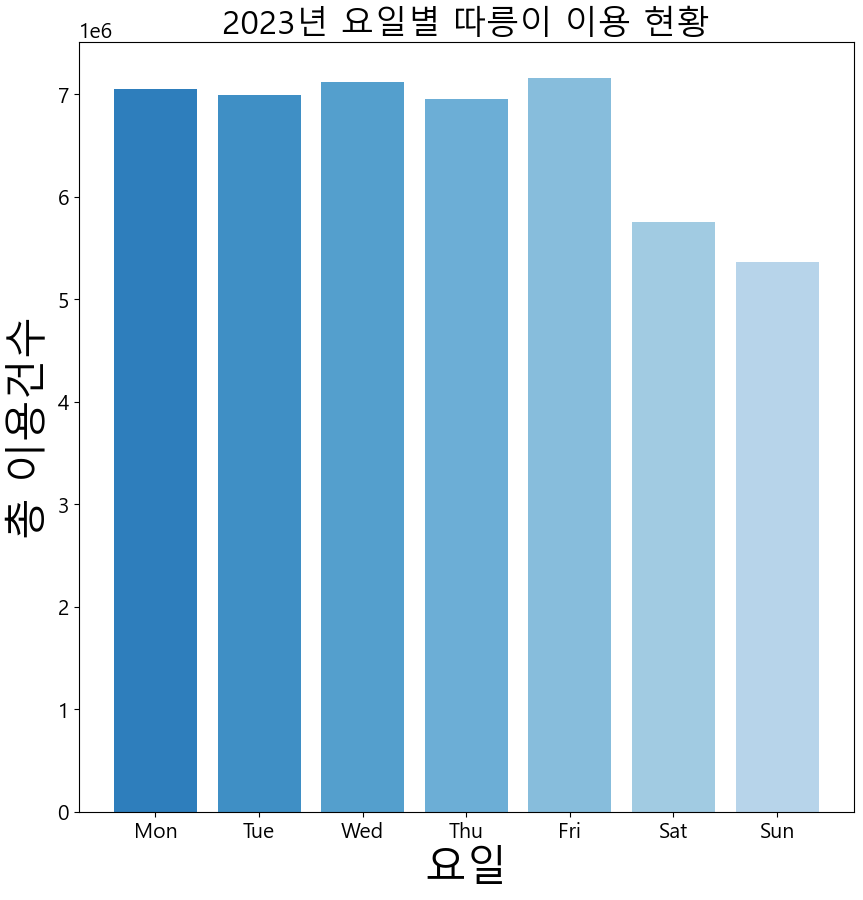

3327

In [6]:
total_usage_by_week = big_df.groupby('WeekNum').agg({'UseTimeM' : 'sum','StartDate' : 'count'})
total_usage_by_week.rename(columns = {'StartDate' : 'TotalUse'}, inplace=True)
total_usage_by_week['UseTimeM'] = (total_usage_by_week['UseTimeM'] / 60).astype(int)
total_usage_by_week.rename(columns={'UseTimeM':'UseTimeH'}, inplace=True)
total_usage_by_week.index.sort_values()
total_usage_by_week.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
#가로 세로 크기 설정
plt.figure(figsize=(10, 10))    
#
# 컬러 선택과 컬러의 시작,끝을 설정하고 몇개로 나눌건지 설정
colors = plt.cm.Blues(np.linspace(0.7, 0.3, len(total_usage_by_week)))
#
#(x,y축 설정, 색설정)
plt.bar(total_usage_by_week.index, total_usage_by_week['TotalUse'], color=colors, label=total_usage_by_week.index)
#
#label 표시하기 (범례)
# plt.legend()
#
#x축 제목, y축 제목, figure 제목 
plt.xlabel('요일')
plt.ylabel('총 이용건수')
plt.title('2023년 요일별 따릉이 이용 현황') 
#
#x,y 축 폰트 크기 
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15) 
# plt.rc('legend', fontsize=10)  # 범례 폰트 크기
plt.rc('axes', labelsize=30)   
plt.rc('font', size=20)# 기본 폰트 크기
#
#파일 저장(형식 설정 가능) 및 보이기 
plt.savefig('data/23년 요일별 이용건수.png') 
plt.show()
del total_usage_by_week
gc.collect()

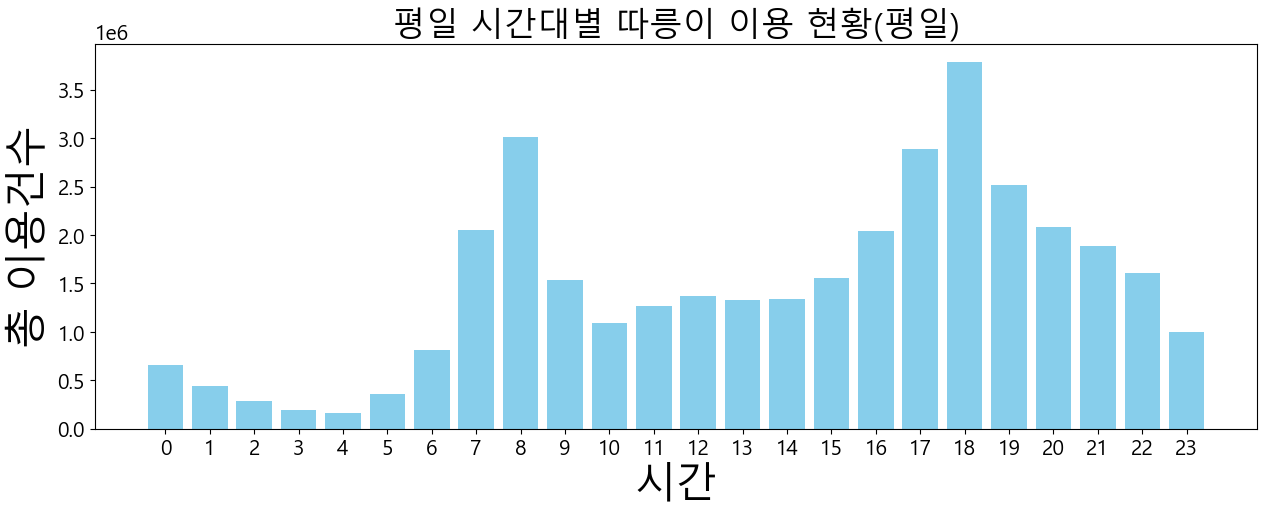

5763

In [7]:
total_usage_by_time_weekday = big_df[big_df['WeekNum'] < 5].groupby('StartTime').agg({'UseTimeM':'sum', 'StartDate':'count'})
total_usage_by_time_weekday.rename(columns = {'StartDate' : 'TotalUse'}, inplace=True)
plt.figure(figsize=(15, 5))
plt.bar(total_usage_by_time_weekday.index, total_usage_by_time_weekday['TotalUse'], color='skyblue')
plt.xlabel('시간')
plt.ylabel('총 이용건수')
plt.title('평일 시간대별 따릉이 이용 현황(평일)')
plt.xticks(range(0, 24, 1))
plt.show()
del total_usage_by_time_weekday
gc.collect()

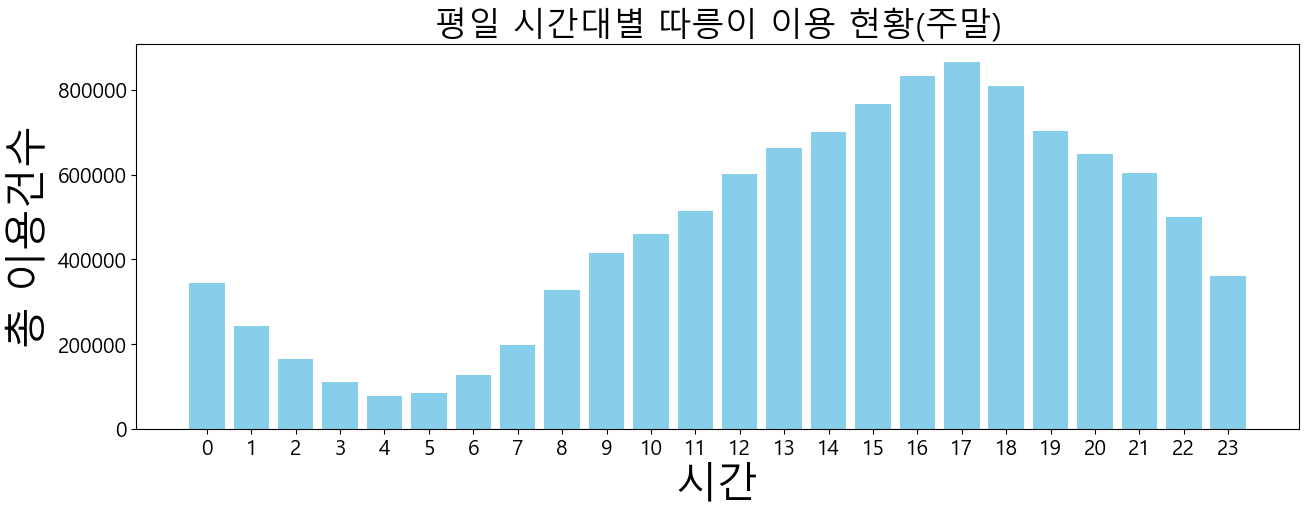

5517

In [8]:
total_usage_by_time_weekend = big_df[big_df['WeekNum'] >= 5].groupby('StartTime').agg({'UseTimeM':'sum', 'StartDate':'count'})
total_usage_by_time_weekend.rename(columns = {'StartDate' : 'TotalUse'}, inplace=True)
plt.figure(figsize=(15, 5))
plt.bar(total_usage_by_time_weekend.index, total_usage_by_time_weekend['TotalUse'], color='skyblue')
plt.xlabel('시간')
plt.ylabel('총 이용건수')
plt.title('평일 시간대별 따릉이 이용 현황(주말)')
plt.xticks(range(0, 24, 1))
plt.show()
del total_usage_by_time_weekend
gc.collect()

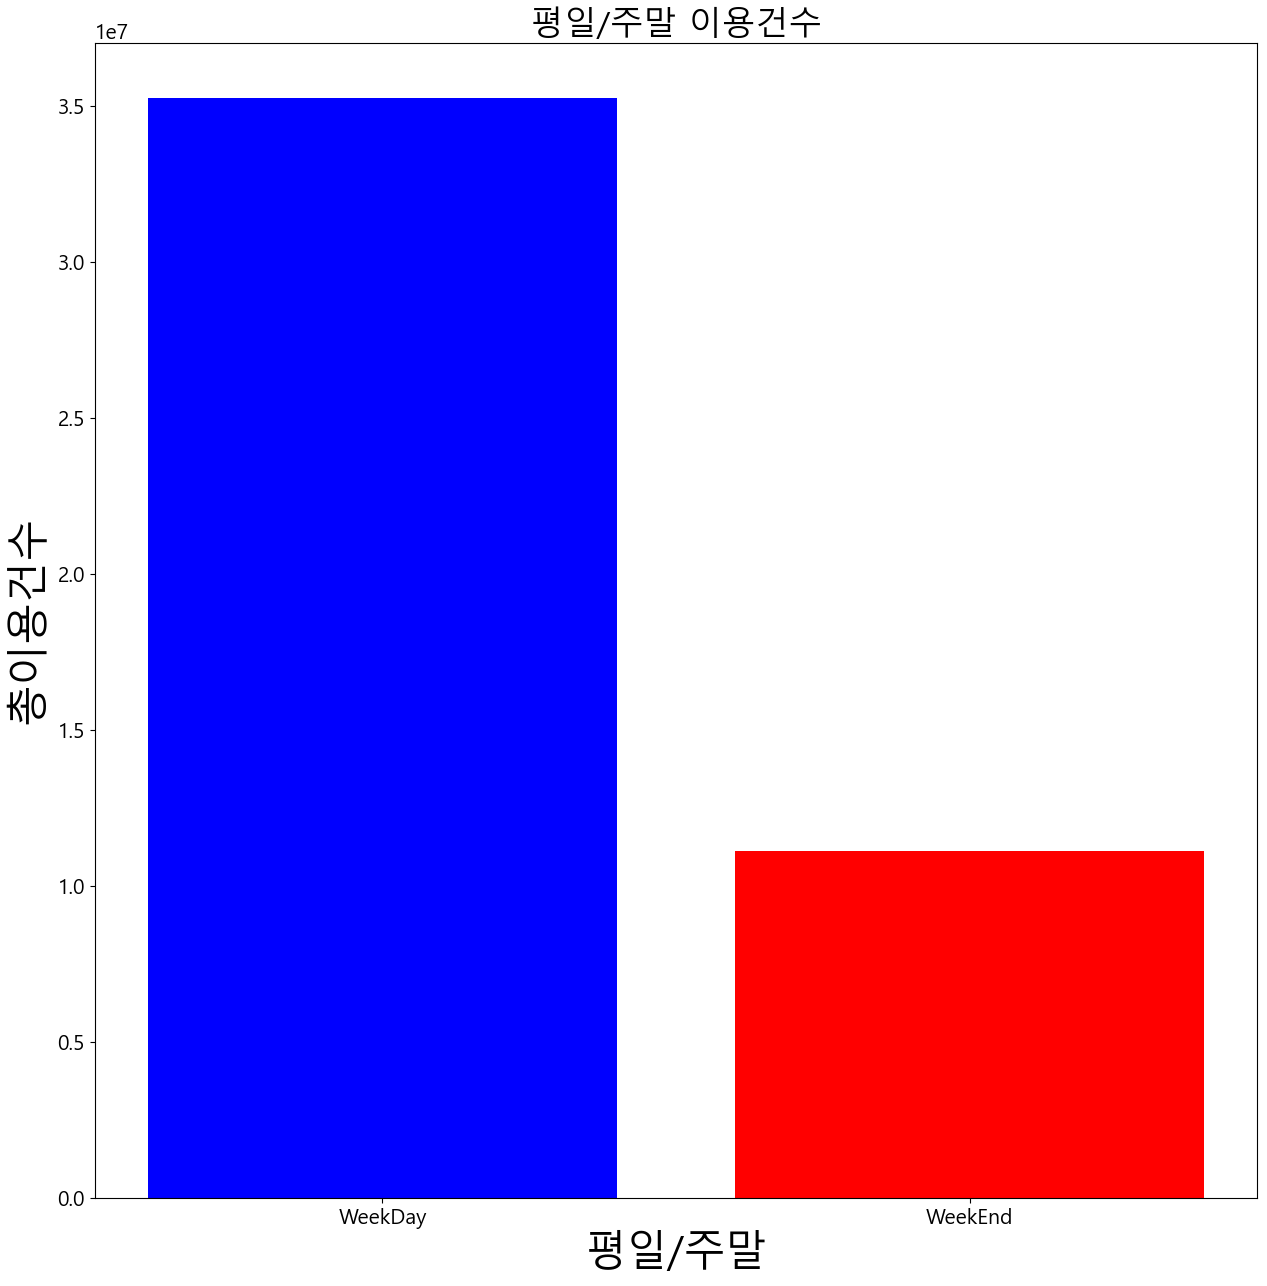

In [9]:
total_usage_by_Bi = big_df.groupby('Bi').agg({'UseTimeM':'sum', 'Bi':'count'})
total_usage_by_Bi.rename(columns = {'Bi' : 'TotalUse'}, inplace=True)
plt.figure(figsize=(15, 15))
plt.bar(total_usage_by_Bi.index, total_usage_by_Bi['TotalUse'], color=['blue', 'red'])
plt.xlabel('평일/주말')
plt.ylabel('총이용건수')
plt.title('평일/주말 이용건수')
plt.show()

2539

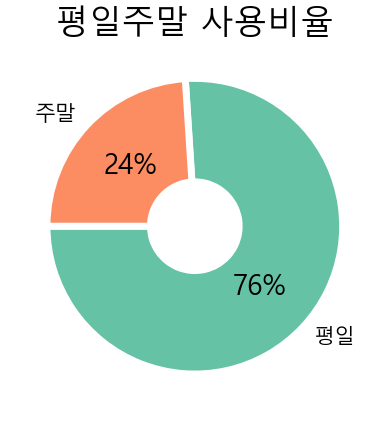

In [10]:
total_usage_by_Bi.head()
weekDay = total_usage_by_Bi['TotalUse']['WeekDay']
weekEnd = total_usage_by_Bi['TotalUse']['WeekEnd']
#
total = weekDay+weekEnd
sizes = [(weekDay/total)*100,(weekEnd/total)*100]
colors = ['#87CEEB', '#1f77b4'] 
labels = ['평일','주말']
# 
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
colors = sns.color_palette('Set2', 2) #sns.color_palette('pastel')[0:2]
plt.pie(sizes, labels = labels, colors = colors, autopct='%.0f%%', wedgeprops = wedgeprops,startangle=180)
plt.title('평일주말 사용비율')
del total_usage_by_Bi
gc.collect()

C:\Users\human\AppData\Local\Temp\ipykernel_21672\3976234743.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_usage_by_gender = big_df.groupby('Gender').agg({'UseTimeM':'sum', 'Gender':'count'})


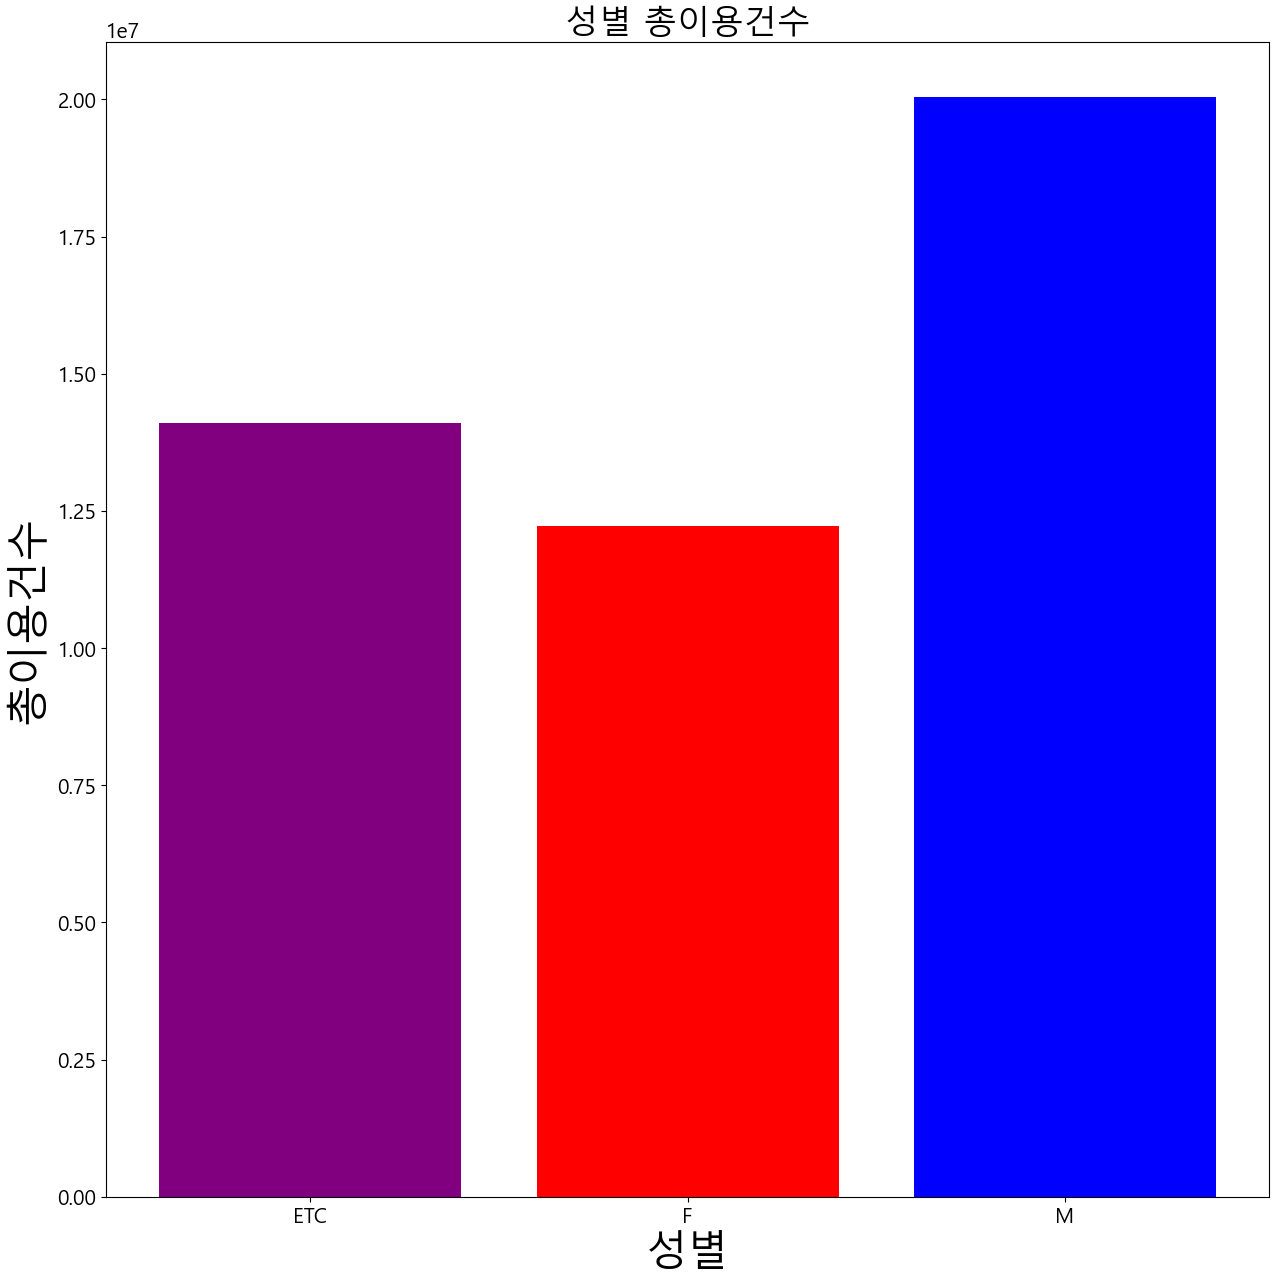

4927

In [11]:
total_usage_by_gender = big_df.groupby('Gender').agg({'UseTimeM':'sum', 'Gender':'count'})
total_usage_by_gender.rename(columns = {'Gender' : 'TotalUse'}, inplace=True)
plt.figure(figsize=(15, 15))
plt.bar(total_usage_by_gender.index, total_usage_by_gender['TotalUse'], color=['purple', 'red', 'blue'])
plt.xlabel('성별')
plt.ylabel('총이용건수')
plt.title('성별 총이용건수')
plt.show()
del total_usage_by_gender
gc.collect()

C:\Users\human\AppData\Local\Temp\ipykernel_21672\3520438044.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_usage_by_birth = big_df.groupby('Birth').agg({'UseTimeM':'sum', 'Birth':'count'})


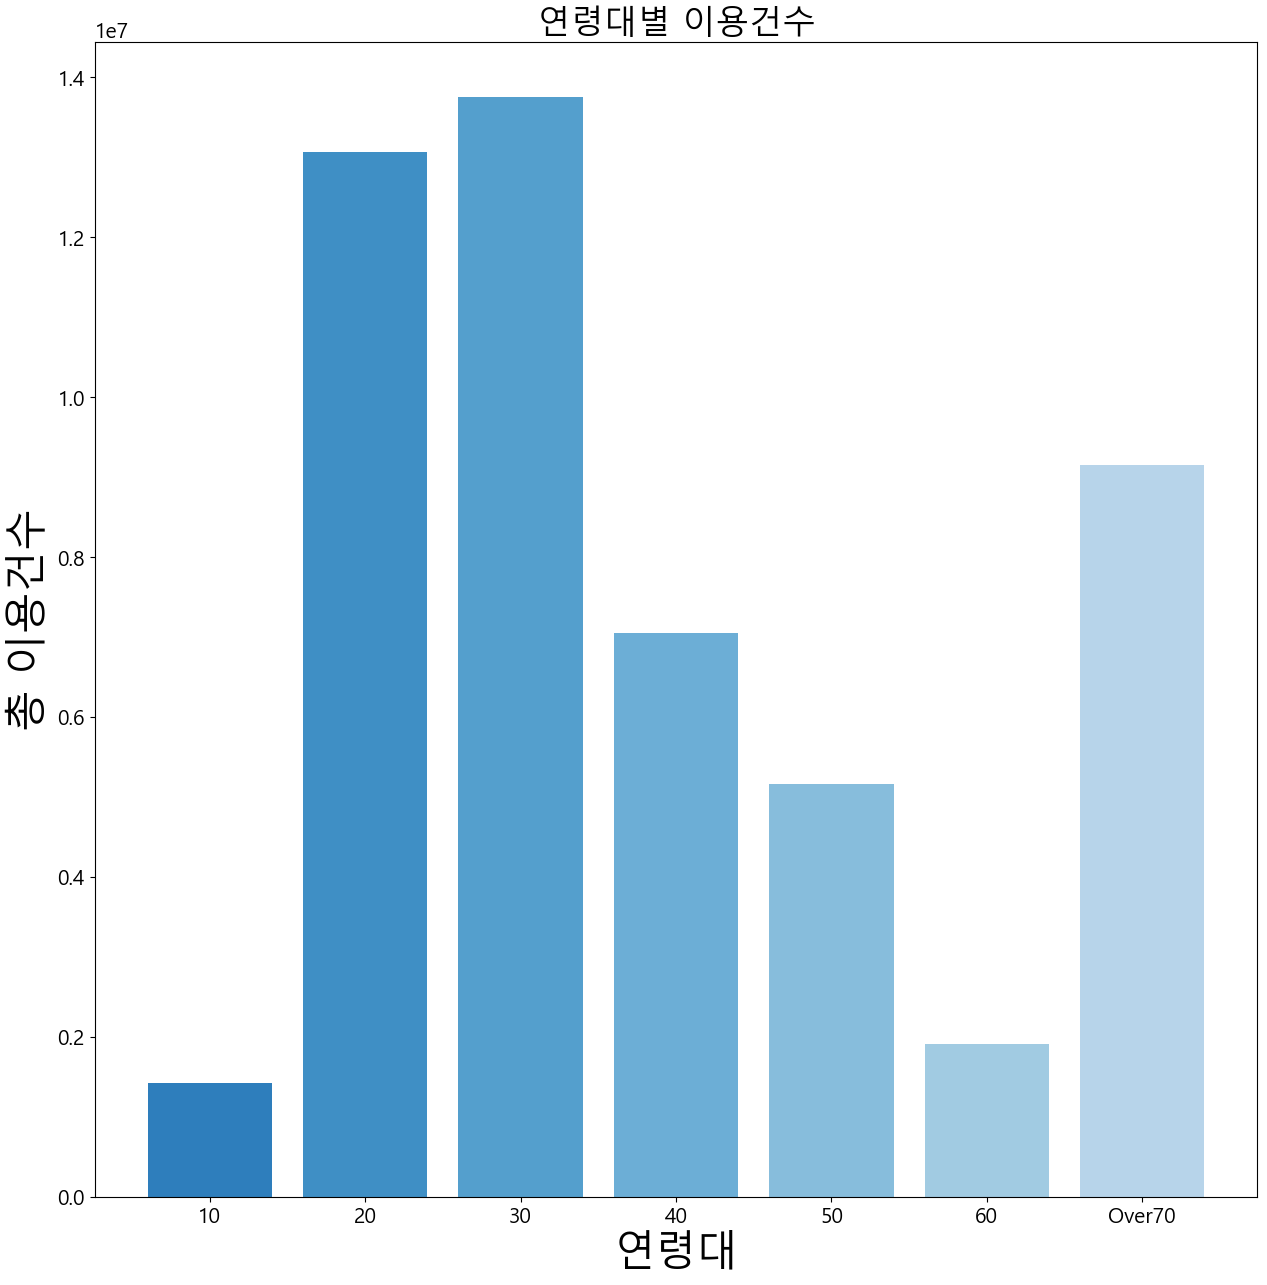

3350

In [12]:
total_usage_by_birth = big_df.groupby('Birth').agg({'UseTimeM':'sum', 'Birth':'count'})
total_usage_by_birth.rename(columns = {'Birth' : 'TotalUse'}, inplace=True)
total_usage_by_birth = total_usage_by_birth.drop(index='ETC')
#
# 최적화 함수 부분에서 타입이 꼬였기에 다시 타입 변경
# 최적화 함수에서 to_numeric으로 변경했기 때문에 다시 int로 변경
# 중간 과정으로 str로 변경 후 int로 변경 해야 합니다.
total_usage_by_birth.index = total_usage_by_birth.index.astype(str).astype(int)
#
over70_total_use = total_usage_by_birth.loc[total_usage_by_birth.index >= 70, 'TotalUse'].sum()
over70_use_time_m = total_usage_by_birth.loc[total_usage_by_birth.index >= 70, 'UseTimeM'].sum()
total_usage_by_birth.loc['Over70'] = [over70_total_use, over70_use_time_m]
total_usage_by_birth.index = total_usage_by_birth.index.astype(str)
total_usage_by_birth.drop(index=['70','80','90'], inplace=True)
plt.figure(figsize=(15, 15))
#
# 컬러 선택과 컬러의 시작,끝을 설정하고 몇개로 나눌건지 설정
colors = plt.cm.Blues(np.linspace(0.7, 0.3, len(total_usage_by_birth)))
#
#(x,y축 설정, 색설정)
plt.bar(total_usage_by_birth.index, total_usage_by_birth['TotalUse'], color=colors, label=total_usage_by_birth.index)
# plt.bar(total_usage_by_birth.index, total_usage_by_birth['TotalUse'], color='skyblue')
plt.ylabel('총 이용건수')
plt.xlabel('연령대')
plt.title('연령대별 이용건수')
# plt.xticks(range(0, 70, 10))
plt.show()
del total_usage_by_birth
gc.collect()

C:\Users\human\AppData\Local\Temp\ipykernel_21672\3249075915.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_df = big_df_weekday.groupby(['StartTime','Gender']).agg({'StartDate':'count'})


3

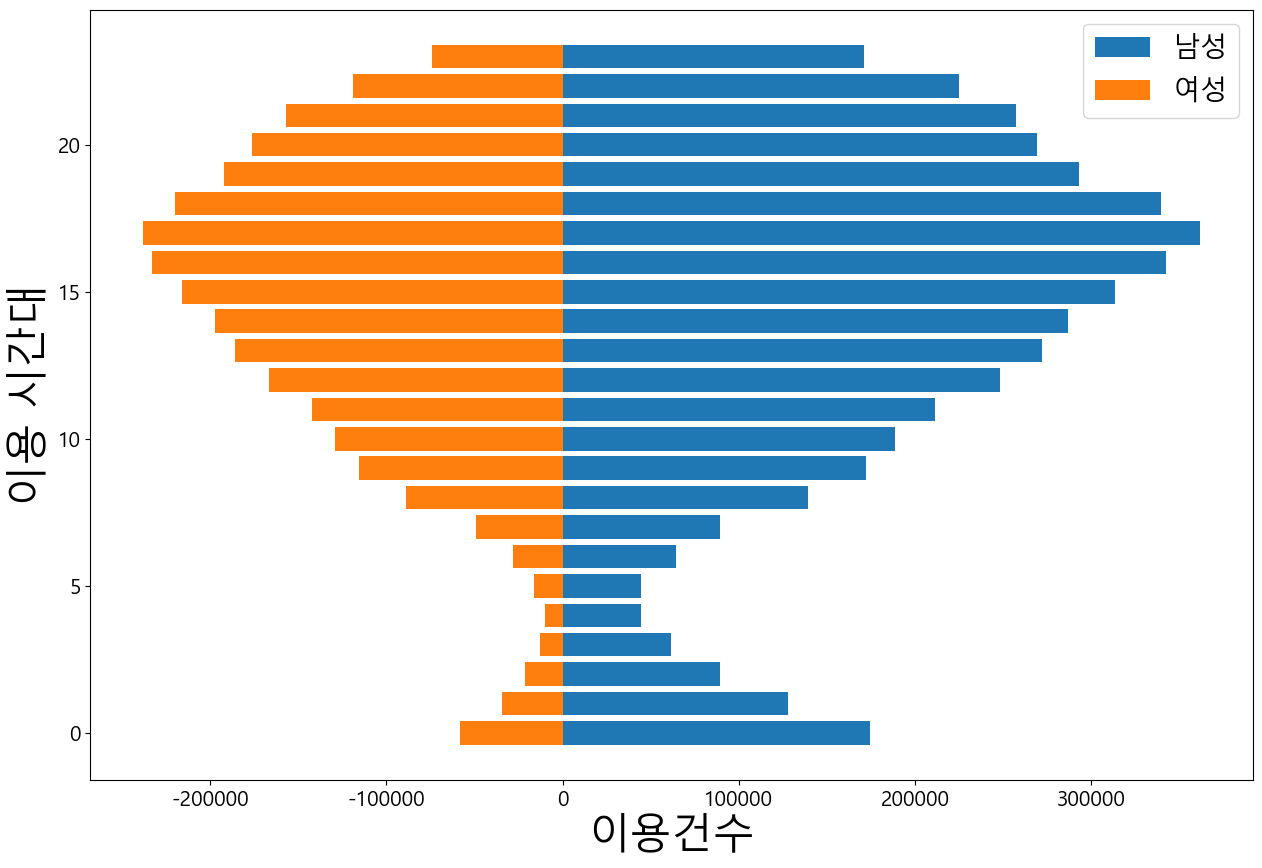

In [13]:
big_df_weekday = big_df[big_df['WeekNum'] >= 5]
new_df = big_df_weekday.groupby(['StartTime','Gender']).agg({'StartDate':'count'})
del big_df_weekday
gc.collect()
women_pop = new_df.loc[new_df.index.get_level_values('Gender') == 'F']
men_pop = new_df.loc[new_df.index.get_level_values('Gender') == 'M']
X = np.arange(24)
#
plt.figure(figsize=(15, 10))
plt.barh(X, men_pop.values.flatten(), label="남성")
plt.barh(X, -women_pop.values.flatten(), label='여성')
plt.xlabel('이용건수')
plt.ylabel('이용 시간대')
plt.legend()
del new_df
gc.collect()

In [14]:
id_gu_dong_df = pd.read_csv('data/id_gu_dong_etc_change.csv', encoding='cp949')
year_df_selected = big_df[['UseTimeM', 'UseDistM','Birth','StartId','EndId']]
id_gu_dong_df_selected = id_gu_dong_df[['Id','Gu','Dong']]
del id_gu_dong_df
gc.collect()
def get_chunks(df, chunk_size):
    num_chunks = len(df) // chunk_size + int(len(df) % chunk_size != 0)
    for i in range(num_chunks):
        # yield 구문은 제너레이터를 리턴합니다.
        # 제너레이터는 이터레이터를 생성해주는 함수입니다.
        # yield 구문을 사용하면 함수는 제너레이터가 되며, 이터레이터처럼 동작합니다.
        # yield 구문을 사용하면 함수는 호출된 위치의 상태를 기억하고 다음 호출 시 이어서 실행합니다.
        # 일반적으로 return 구문은 함수를 종료하고 값을 반환하지만, 
        # yield 구문은 값을 반환한 후 일시정지하고 다음 호출 시 이어서 실행합니다.    
        # 이것은 메모리 측면에서 효율적입니다.
        # for 문의 모든 값을 한번에 return 하는 것이 아니라, 
        # yield를 통해 하나씩 반환합니다.
        yield df[i*chunk_size:(i+1)*chunk_size]
        #
    #
#
def merge_and_optimize_chunks(year_df_selected, id_gu_dong_df_selected, chunk_size=100000):
    merged_chunks = []
    # 청크 단위로 year_df_selected를 처리
    for year_chunk in get_chunks(year_df_selected, chunk_size):
        year_chunk = optimize_dataframe(year_chunk)
        # year_chunk와 id_gu_dong_df_selected 병합
        merged_chunk = pd.merge(year_chunk, id_gu_dong_df_selected, left_on='StartId', right_on='Id', how='left')
        # 최적화 후 청크 리스트에 추가
        merged_chunk = optimize_dataframe(merged_chunk)
        merged_chunks.append(merged_chunk)
        del year_chunk, merged_chunk
        gc.collect()
    # 모든 청크를 병합
    final_df = pd.concat(merged_chunks, ignore_index=True)
    return final_df
# 최적화된 청크 병합 데이터프레임 생성
map_df = merge_and_optimize_chunks(year_df_selected, id_gu_dong_df_selected)
# 메모리 해제
gc.collect()
del year_df_selected
gc.collect()
map_df.drop(columns=['StartId'], inplace=True)
map_st_count_df = map_df.groupby('Gu').agg({
    'Id':'nunique',
    'UseDistM':'sum'
    })
# size()는 그룹별 데이터의 개수를 반환합니다.
map_st_count_df['Count'] = map_df.groupby('Gu').size() 
map_st_count_df.reset_index(inplace=True)
del map_df
gc.collect()
map_st_count_df.reset_index(inplace=True)
#
# 자료가 얼마 되지 않아 수기로 작성
data = {
    '종로구': 32.08,
    '중구': 22.39,
    '용산구': 32.53,
    '성동구': 29.18,
    '광진구': 49.3,
    '동대문구': 38.32,
    '중랑구': 9.75,
    '성북구': 16.84,
    '강북구': 8.7,
    '도봉구': 12.94,
    '노원구': 43.99,
    '은평구': 44.65,
    '서대문구': 32.09,
    '마포구': 67.4,
    '양천구': 56.49,
    '강서구': 77.34,
    '구로구': 32.55,
    '금천구': 9.16,
    '영등포구': 64.24,
    '동작구': 14.3,
    '관악구': 27.73,
    '서초구': 44.24,
    '강남구': 113.39,
    '송파구': 99.72,
    '강동구': 76.62
}
road_S = pd.Series(data)
road_df = pd.DataFrame(road_S, columns=['Road'])
del data, road_S
gc.collect()
end_df = big_df[['StartId','Birth','EndId','StartDate','UseTimeM','UseDistM']]

C:\Users\human\AppData\Local\Temp\ipykernel_21672\2010610134.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], downcast='float')
C:\Users\human\AppData\Local\Temp\ipykernel_21672\2010610134.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category')
C:\Users\human\AppData\Local\Temp\ipykernel_21672\2010610134.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

C:\Users\human\AppData\Local\Temp\ipykernel_21672\3470077042.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  week_age=df_age.groupby(["Bi","Birth"]).agg({"Birth":"count"})


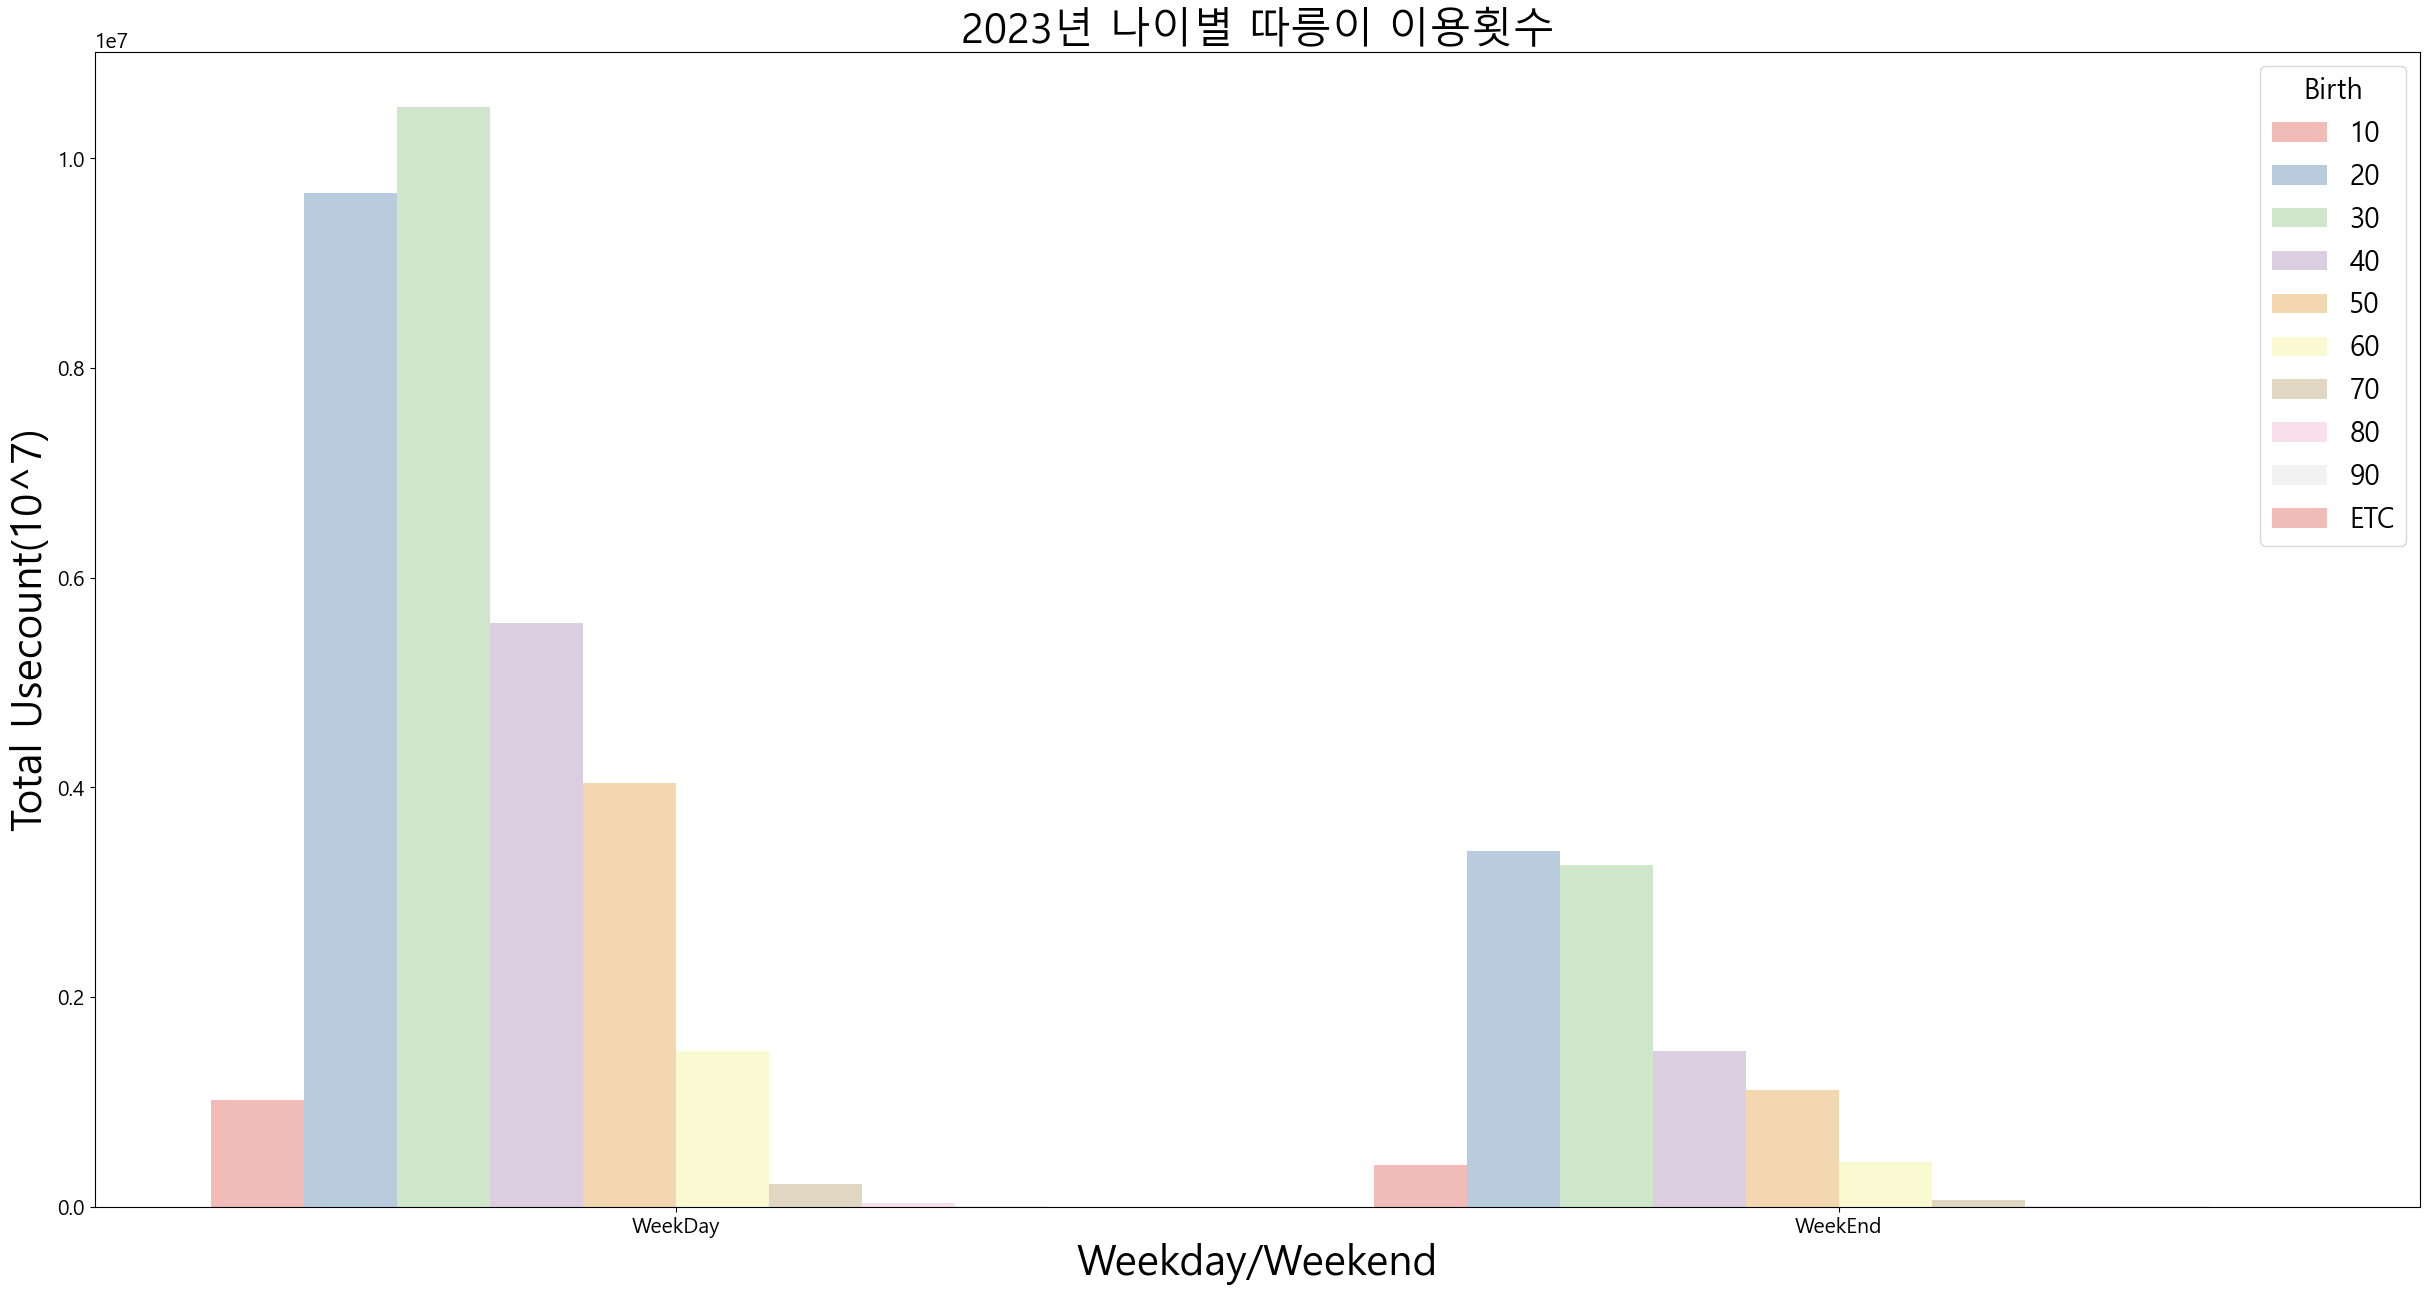

5996

In [15]:
df_age = big_df[['Birth','StartDate','Bi']]
#ETC 제거 
df_age = df_age[df_age['Birth'] != "ETC"] 
week_age=df_age.groupby(["Bi","Birth"]).agg({"Birth":"count"})
week_age.rename(columns={"Birth":"Count"},inplace=True)
week_age.reset_index(inplace=True)
#빈 피규어 생성
plt.figure(figsize=(30,15))
#x축 요일 y축 빈도수, hue= 나이 palette = color
sns.barplot(x=week_age["Bi"],y=week_age["Count"],hue=week_age["Birth"],palette="Pastel1")
#제목 설정
plt.title("2023년 나이별 따릉이 이용횟수",fontsize=30)
#전체 폰트 사이즈
plt.rc('font', size=30)
#y축 라벨 설정 
plt.ylabel("Total Usecount(10^7)")
plt.xlabel("Weekday/Weekend")
plt.show()
del week_age
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Index: 42701670 entries, 0 to 46388233
Data columns (total 3 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Birth      int64         
 1   StartDate  datetime64[ns]
 2   Bi         object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.3+ GB


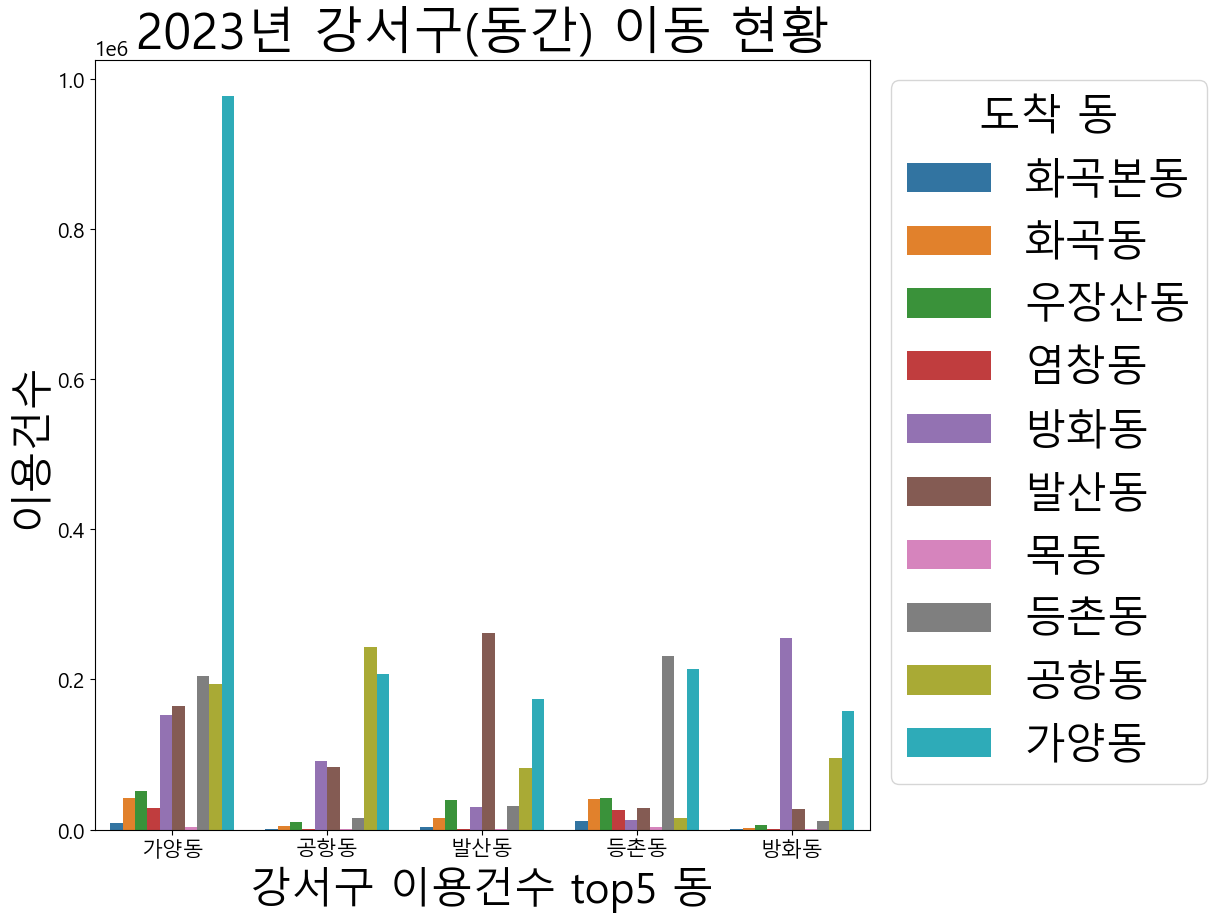

In [16]:
#정렬을 위해서 Birth 숫자로 변경 
df_age['Birth'] = pd.to_numeric(df_age['Birth'])
del df_age
gc.collect()

#ETC drop
data_df = big_df
data_df = data_df[data_df['Birth']!='ETC']
data_df = data_df[data_df['Gender']!='ETC']

local_df_new = id_gu_dong_df_selected
all_each_df = big_df[['StartDate','StartId','EndId']]
local_selected_df = local_df_new[local_df_new["Gu"].isin(["강서구"])] 
all_df = pd.merge(local_selected_df,all_each_df,left_on="Id",right_on="StartId")
all_gu_dong_df = pd.merge(all_df,local_selected_df,left_on="EndId",right_on="Id")

del all_each_df, local_selected_df, all_df
gc.collect()

all_gu_dong_df["matching"] =np.where(all_gu_dong_df["Dong_y"] == all_gu_dong_df["Dong_x"],"0","1")
all_gu_dong_df["holl"] =np.where(all_gu_dong_df["Gu_y"] == all_gu_dong_df["Gu_x"],"0","1")

#대여동의 빈도수 해서 matching
matching34 =all_gu_dong_df.groupby("Dong_x").agg({"Dong_x":"count"})

#groupby 대여건수 이름 변경
matching34.rename(columns={"Dong_x":"대여건수"},inplace=True)
matching34.reset_index(inplace=True)

#대여동과 반납동이 matching
matcing=all_gu_dong_df.groupby(['Dong_x',"Dong_y"]).agg({"matching":"count"})

del all_gu_dong_df
gc.collect()

matcing.reset_index(inplace=True)
merged=pd.merge(matching34,matcing)

del matching34,matcing
gc.collect()

merged_gr=merged.groupby(["Dong_x","대여건수","Dong_y"]).sum()
merged_gr2=merged_gr.sort_index(level="대여건수",ascending=False)

del merged, merged_gr
gc.collect()

ganseo_top5 = merged_gr2.iloc[0:50]

del merged_gr2
gc.collect()

plt.figure(figsize=(10, 10))
sns.barplot(x='Dong_x',y='matching',hue="Dong_y",data =ganseo_top5)
sns.set_palette('Paired')
plt.title("2023년 강서구(동간) 이동 현황")
plt.xlabel("강서구 이용건수 top5 동")
plt.ylabel("이용건수")
plt.legend(title='도착 동', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

del big_df
gc.collect()

<Figure size 4000x4000 with 0 Axes>

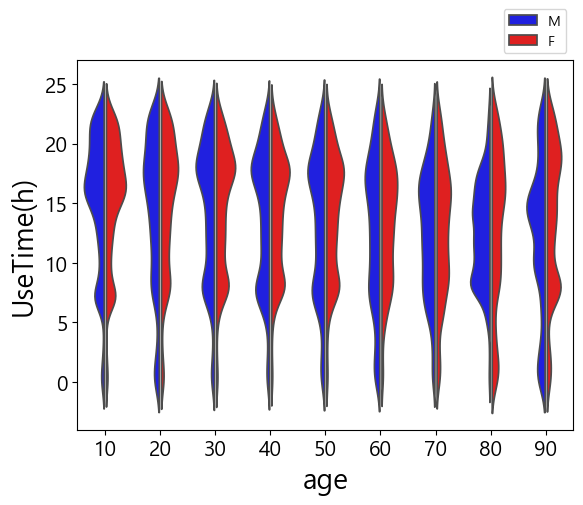

In [17]:
#정렬을 위해서 Birth 숫자로 변경 
data_df['Birth'] = pd.to_numeric(data_df['Birth'])
vi = data_df[['StartTime','Birth','Gender']]

del data_df
gc.collect()

vi['Gender'] = vi['Gender'].astype('object')

#빈 피규어 생성 (state-based)
plt.figure(figsize=(40,40))
# 컬러 지정
palette = {"M": "blue", "F": "red"}
#fig는 빈 프레임의 수이고 ax는 실질적으로 그래프가 들어가는 위치임. 그래서 fig 1개에 ax 1개를 부여함 
fig, ax = plt.subplots(1,1)
# ax는 ax를 지정해서 각 영역별로 나눠짐(여기서 영역은 Birth) 
sns.violinplot(x=vi["Birth"],y=vi['StartTime'],hue=vi["Gender"],gap=0.1,split=True,inner=None,ax=ax,bw_method= 0.2,palette=palette)
plt.xlabel("age",fontsize=20)
plt.ylabel("UseTime(h)",fontsize=20)
plt.legend(loc='lower right', bbox_to_anchor=(1.0,1.0), fontsize=10)
plt.show()

del vi
gc.collect()

C:\Users\human\AppData\Local\Temp\ipykernel_21672\2010610134.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], downcast='float')
C:\Users\human\AppData\Local\Temp\ipykernel_21672\2010610134.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category')
C:\Users\human\AppData\Local\Temp\ipykernel_21672\2010610134.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

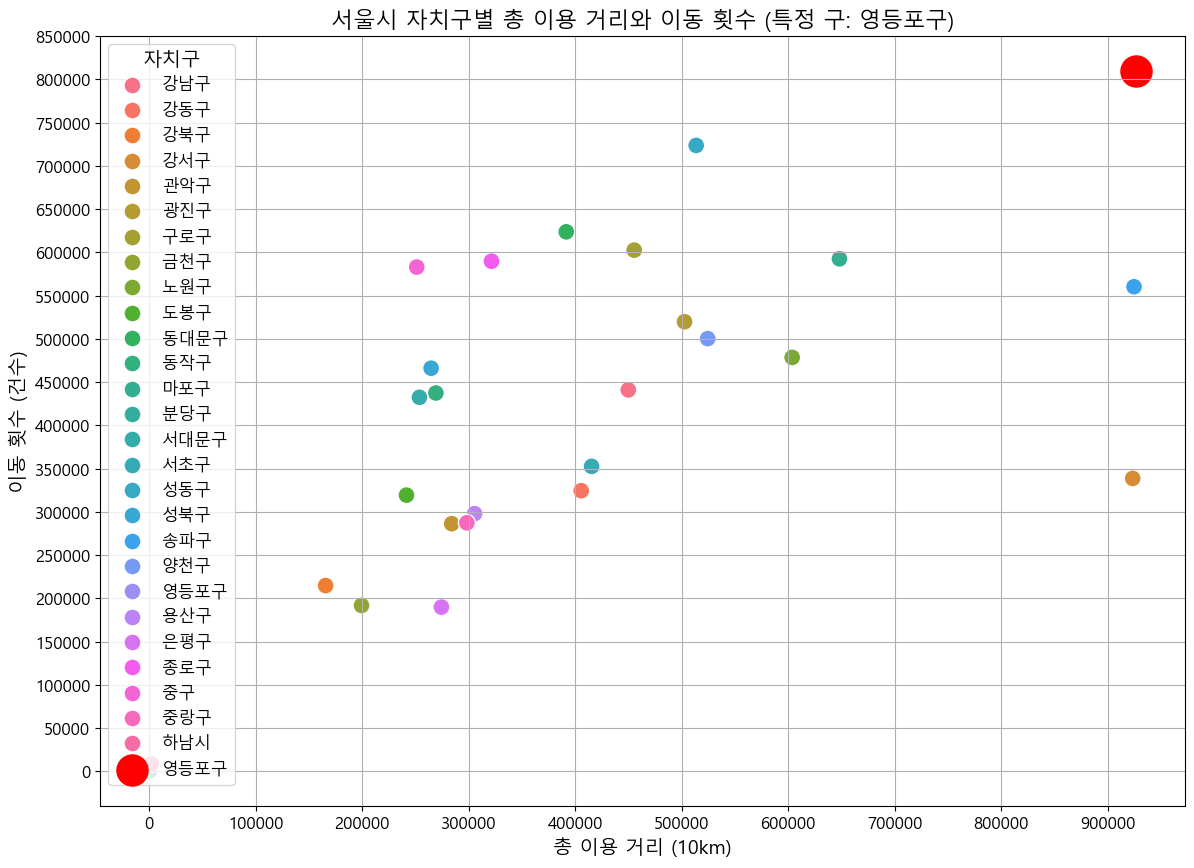

In [18]:
# 청크 단위로 병합 및 최적화 함수
def merge_and_optimize_chunks(end_df, id_gu_dong_df_selected, chunk_size=100000):
    merged_chunks = []
    # 청크 단위로 end_df를 처리
    for end_chunk in get_chunks(end_df, chunk_size):
        end_chunk = optimize_dataframe(end_chunk)
        # 첫 번째 병합
        merged_1st = pd.merge(end_chunk, id_gu_dong_df_selected, left_on='StartId', right_on='Id', how='left')
        # 두 번째 병합
        merged_2nd = pd.merge(merged_1st, id_gu_dong_df_selected, left_on='EndId', right_on='Id', how='left')
        # 결측값이 있는 행 제거
        merged_2nd.dropna(inplace=True)
        # 필요 없는 컬럼 제거
        merged_2nd.drop(columns=['Id_x', 'Id_y'], inplace=True)
        # 최적화 후 청크 리스트에 추가
        merged_2nd = optimize_dataframe(merged_2nd)
        merged_chunks.append(merged_2nd)
        del end_chunk, merged_1st, merged_2nd
        gc.collect()
    # 모든 청크를 병합
    final_df = pd.concat(merged_chunks, ignore_index=True)
    return final_df
# 최적화된 청크 병합 데이터프레임 생성
move_gu_df_2nd = merge_and_optimize_chunks(end_df, id_gu_dong_df_selected)
# 메모리 해제
gc.collect()

del id_gu_dong_df_selected, end_df
gc.collect()

move_gu_df_3rd = move_gu_df_2nd[move_gu_df_2nd['Gu_x'] == move_gu_df_2nd['Gu_y']]
move_gu_df_4th = move_gu_df_2nd[move_gu_df_2nd['Gu_x'] != move_gu_df_2nd['Gu_y']]
move_gu_df_3rd['Move'] = 0
move_gu_df_4th['Move'] = 1
move_gu_df_3rd['NotMove'] = 1
move_gu_df_4th['NotMove'] = 0

del move_gu_df_2nd
gc.collect()

move_gu_df_5th = pd.concat([move_gu_df_3rd, move_gu_df_4th])

del move_gu_df_3rd, move_gu_df_4th
gc.collect()

df2 = move_gu_df_5th[move_gu_df_5th['Gu_x'] == '강서구']
df = move_gu_df_5th.groupby(['Gu_x']).agg({'UseDistM' : 'sum', 'UseTimeM' : 'sum' ,'Move' : 'sum', 'NotMove' : 'sum'})
df.reset_index(inplace=True)
df['UseDistM'] = df['UseDistM'] / 10000
specific_gu = '영등포구'
# 산점도 그리기
plt.figure(figsize=(14, 10))
sns.scatterplot(x='UseDistM', y='Move', hue='Gu_x', data=df, s=150)  # 점 크기 조정 및 색상 구분
plt.scatter(df[df['Gu_x'] == specific_gu]['UseDistM'], df[df['Gu_x'] == specific_gu]['Move'], s=500, color='red', label=specific_gu)  # 특정 구 강조
plt.xlabel('총 이용 거리 (10km)', fontsize=14)  # x축 라벨 크기 조정
plt.ylabel('이동 횟수 (건수)', fontsize=14)  # y축 라벨 크기 조정
plt.title(f'서울시 자치구별 총 이용 거리와 이동 횟수 (특정 구: {specific_gu})', fontsize=16)  # 제목 크기 조정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)  # y축 눈금 라벨 크기 조정
plt.legend(title='자치구', fontsize=12, title_fontsize=14)  # 범례 추가
plt.grid(True)  # 그리드 추가
plt.locator_params(axis='x', nbins=20)
plt.locator_params(axis='y', nbins=20)
plt.show()

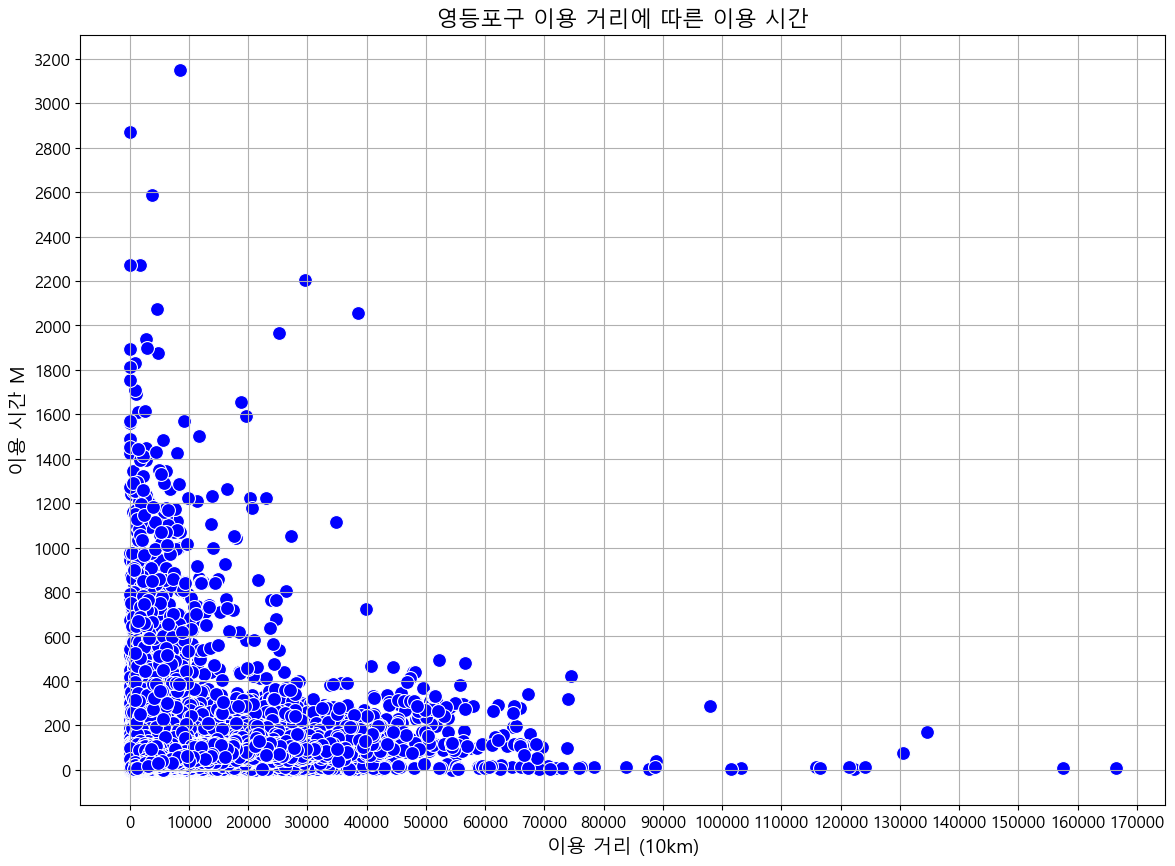

In [19]:
# 산점도 그리기
plt.figure(figsize=(14, 10))
sns.scatterplot(x='UseDistM', y='UseTimeM', data=df2, s=100, color='blue')  # 강남구 데이터 점 크기 조정 및 색상 설정
plt.xlabel('이용 거리 (10km)', fontsize=14)  # x축 라벨 크기 조정
plt.ylabel('이용 시간 M', fontsize=14)  # y축 라벨 크기 조정
plt.title('영등포구 이용 거리에 따른 이용 시간', fontsize=16)  # 제목 크기 조정
plt.xticks(fontsize=12)  # x축 눈금 라벨 크기 조정
plt.yticks(fontsize=12)  # y축 눈금 라벨 크기 조정
plt.locator_params(axis='x', nbins=20)
plt.locator_params(axis='y', nbins=20)
plt.grid(True)  # 그리드 추가
plt.show()

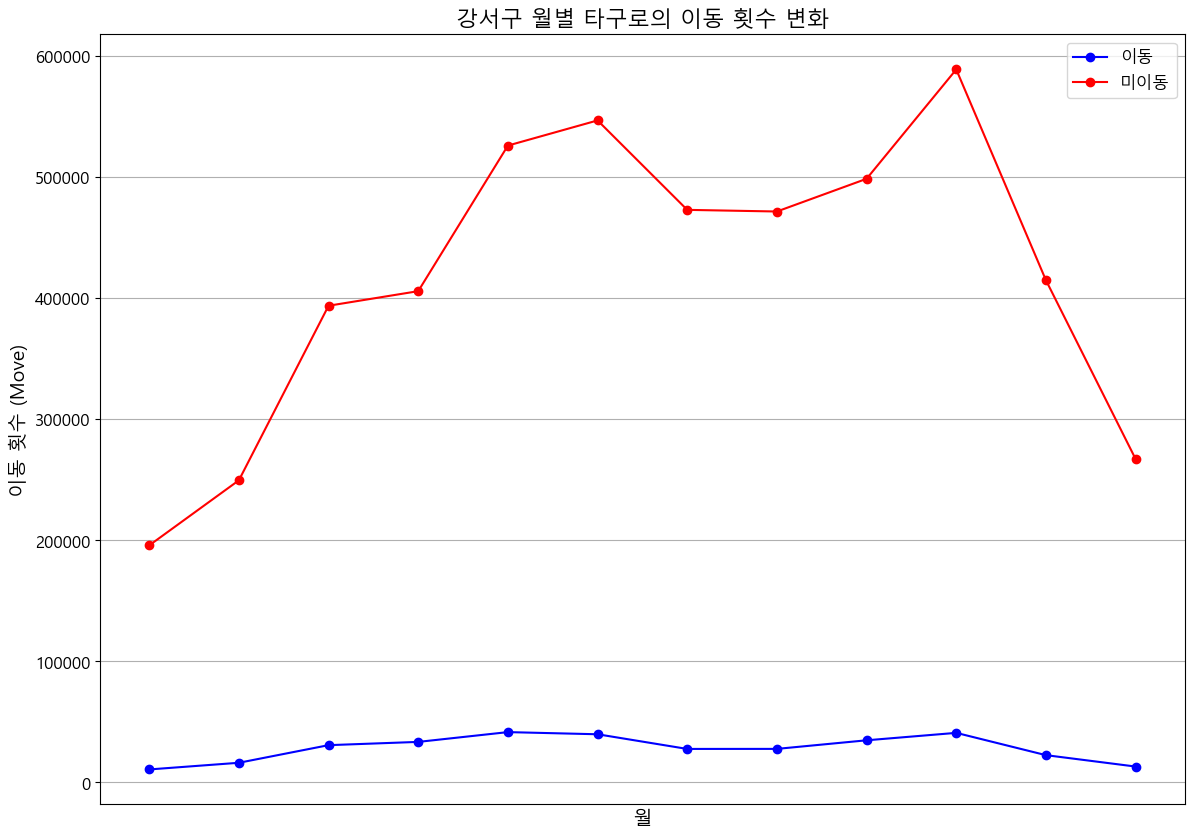

In [20]:
df3 = df2.groupby('StartDate').agg({'UseDistM' : 'sum', 'UseTimeM' : 'sum','Move':'sum','NotMove':'sum'})
df3.reset_index(inplace=True)
df3['StartDate'] = pd.to_datetime(df3['StartDate']).dt.month
df4 = df3.groupby('StartDate').agg({'UseDistM' : 'sum', 'UseTimeM' : 'sum','Move':'sum','NotMove':'sum'})
df4.reset_index(inplace=True)
# 'Month' 컬럼을 datetime 형식으로 변환
df4['StartDate'] = pd.to_datetime(df4['StartDate'])
# 이동 횟수 변화 시각화
plt.figure(figsize=(14, 10))
plt.plot(df4['StartDate'], df4['Move'], marker='o', color='blue')
plt.plot(df4['StartDate'], df4['NotMove'], marker='o', color='red')
plt.legend(['이동', '미이동'], fontsize=12)  # 범례 추가
plt.xlabel('월', fontsize=14)  # x축 라벨 크기 조정
plt.ylabel('이동 횟수 (Move)', fontsize=14)  # y축 라벨 크기 조정
plt.title('강서구 월별 타구로의 이동 횟수 변화', fontsize=16)  # 제목 크기 조정
plt.xticks(fontsize=12)  # x축 눈금 라벨 크기 조정
plt.yticks(fontsize=12)  # y축 눈금 라벨 크기 조정
plt.grid(True)
plt.show()

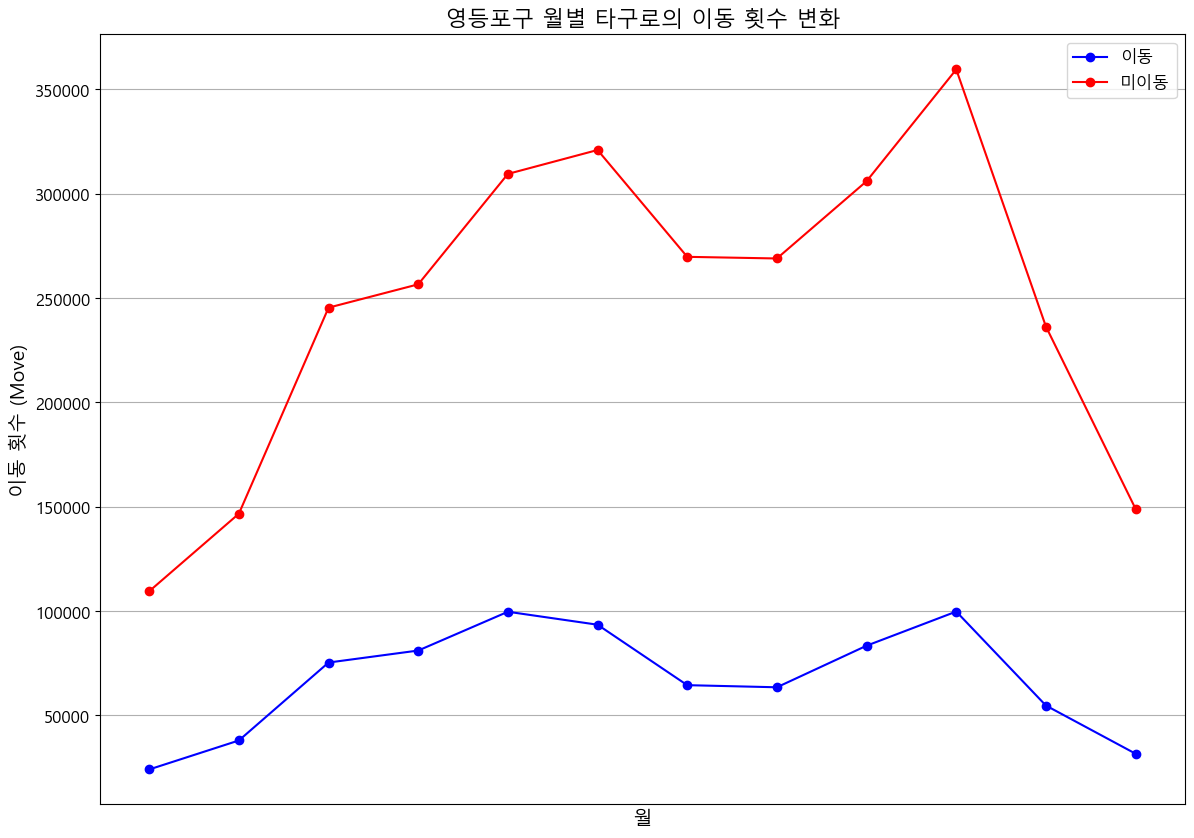

10753

In [21]:
df2 = move_gu_df_5th[move_gu_df_5th['Gu_x'] == '영등포구']
df3 = df2.groupby('StartDate').agg({'UseDistM' : 'sum', 'UseTimeM' : 'sum','Move':'sum','NotMove':'sum'})
df3.reset_index(inplace=True)
df3['StartDate'] = pd.to_datetime(df3['StartDate']).dt.month
df4 = df3.groupby('StartDate').agg({'UseDistM' : 'sum', 'UseTimeM' : 'sum','Move':'sum','NotMove':'sum'})
df4.reset_index(inplace=True)
# 'Month' 컬럼을 datetime 형식으로 변환
df4['StartDate'] = pd.to_datetime(df4['StartDate'])
# 이동 횟수 변화 시각화
plt.figure(figsize=(14, 10))
plt.plot(df4['StartDate'], df4['Move'], marker='o', color='blue')
plt.plot(df4['StartDate'], df4['NotMove'], marker='o', color='red')
plt.legend(['이동', '미이동'], fontsize=12)  # 범례 추가
plt.xlabel('월', fontsize=14)  # x축 라벨 크기 조정
plt.ylabel('이동 횟수 (Move)', fontsize=14)  # y축 라벨 크기 조정
plt.title('영등포구 월별 타구로의 이동 횟수 변화', fontsize=16)  # 제목 크기 조정
plt.xticks(fontsize=12)  # x축 눈금 라벨 크기 조정
plt.yticks(fontsize=12)  # y축 눈금 라벨 크기 조정
plt.grid(True)
plt.show()

del df3
gc.collect()

C:\Users\human\AppData\Local\Temp\ipykernel_21672\3391468898.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df3 = df2.groupby(['Gu_y', 'Birth']).agg({'UseDistM' : 'sum', 'UseTimeM' : 'sum','Move':'sum','NotMove':'sum'})
C:\Users\human\AppData\Local\Temp\ipykernel_21672\3391468898.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filtered.groupby(['Gu_y', 'Birth'])['Move'].sum().unstack().fillna(0)


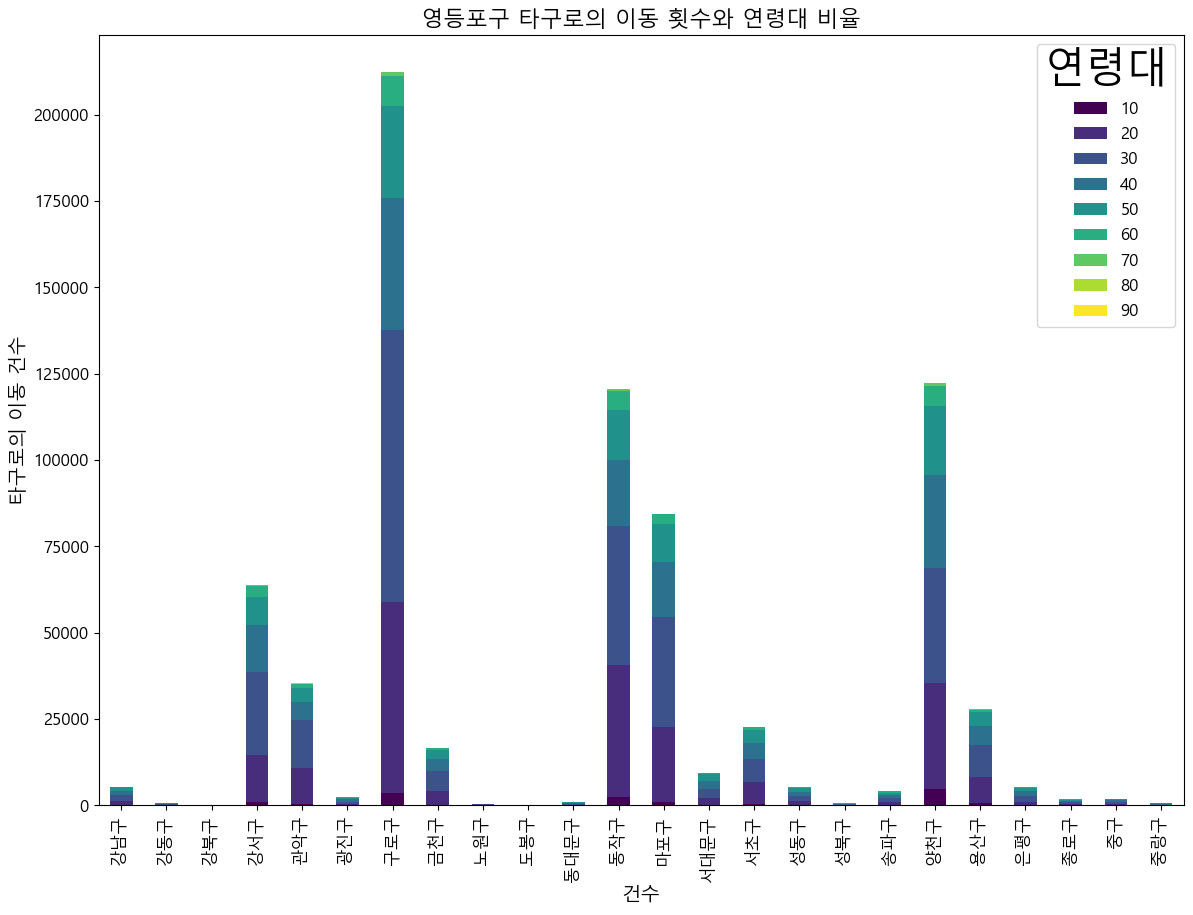

In [22]:
df3 = df2.groupby(['Gu_y', 'Birth']).agg({'UseDistM' : 'sum', 'UseTimeM' : 'sum','Move':'sum','NotMove':'sum'})
df3.reset_index(inplace=True)
df3.drop(df3[df3['Gu_y'] == '영등포구'].index, inplace=True)
df_filtered = df3[~df3['Birth'].isin(['ETC']) & ~df3['Gu_y'].isin(['하남시', '분당구', '영등포구'])]
# 'Gu_y'와 'Birth'에 따라 'Move' 열을 집계
grouped = df_filtered.groupby(['Gu_y', 'Birth'])['Move'].sum().unstack().fillna(0)
grouped = grouped[~grouped.index.isin(['하남시', '분당구', '영등포구'])]
grouped = grouped.loc[:, ~grouped.columns.isin(['ETC'])]
# 스택드 바 차트 그리기
fig, ax = plt.subplots(figsize=(14, 10))
grouped.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
# 라벨 및 제목 설정
ax.set_xlabel('건수', fontsize=14)
ax.set_ylabel('타구로의 이동 건수', fontsize=14)
ax.set_title('영등포구 타구로의 이동 횟수와 연령대 비율', fontsize=16)
ax.legend(title='연령대', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [23]:
move_gu_df_6th = move_gu_df_5th.groupby(['Gu_x']).agg({'Move':'sum','NotMove':'sum'})
move_gu_1_df = move_gu_df_5th[move_gu_df_5th['Move'] == 1]
move_gu_1_df.drop(columns=['NotMove'], inplace=True)
move_gu_0_df = move_gu_df_5th[move_gu_df_5th['NotMove'] == 1]
move_gu_0_df.drop(columns=['Move'], inplace=True)
move_gu_df_6th['Result'] = move_gu_df_6th['Move'] / (move_gu_df_6th['Move'] + move_gu_df_6th['NotMove']) * 100
move_gu_df_6th['Gu'] = move_gu_df_6th.index
move_gu_2_df = move_gu_1_df.groupby(['Gu_x','Gu_y']).agg({'Move':'sum'})

del move_gu_1_df
gc.collect()

move_gu_3_df = move_gu_0_df.groupby(['Gu_x','Dong_x','Dong_y']).agg({'NotMove':'sum'})
move_gu_3_df.index.get_level_values('Gu_x')

del move_gu_0_df
gc.collect()

move_gu_df_2nd_road = move_gu_df_5th.groupby('Gu_x').agg({'UseDistM':'sum','UseTimeM':'sum','Gu_x':'count'})

del move_gu_df_5th
gc.collect()

move_gu_df_2nd_road['Gu'] = move_gu_df_2nd_road.index
road_df['Gu'] = road_df.index

# 청크 단위로 move_gu_df_2nd_road와 road_df 병합 및 최적화
def merge_with_road_df(move_gu_df_2nd_road, road_df, chunk_size=100000):
    merged_chunks = []
    # 청크 단위로 move_gu_df_2nd_road를 처리
    for chunk in get_chunks(move_gu_df_2nd_road, chunk_size):
        chunk = optimize_dataframe(chunk)
        # road_df와 병합
        merged_chunk = pd.merge(chunk, road_df, left_on='Gu', right_on='Gu', how='left')
        # 최적화 후 청크 리스트에 추가
        merged_chunk = optimize_dataframe(merged_chunk)
        merged_chunks.append(merged_chunk)
        del chunk, merged_chunk
        gc.collect()
    # 모든 청크를 병합
    final_df = pd.concat(merged_chunks, ignore_index=True)
    return final_df
# 병합 및 최적화된 데이터프레임 생성
road_mean_df = merge_with_road_df(move_gu_df_2nd_road, road_df)
gc.collect()

del move_gu_df_2nd_road
gc.collect()

road_mean_df['UseDistK'] = (road_mean_df['UseDistM'] / 1000).astype(int)
road_mean_df.rename(columns = {'Gu_x':'Count'}, inplace=True)
road_mean_df['DistKMean'] = (road_mean_df['Road'] / road_mean_df['UseDistK']) *100000
road_mean_df['UseTimeH'] = (road_mean_df['UseTimeM'] / 60).astype(int)
road_mean_df['TimeHMean'] = (road_mean_df['Road'] / road_mean_df['UseTimeH']) *10000
road_mean_df['CountMean'] = road_mean_df['Road'] / road_mean_df['Count'] * 10000

# 원하는 데이터를 서울시 지도에 시각화 해주는 함수
def create_map(map_df,map_colunmn_ls,color,legend ,filename):
    # GeoJSON 파일 URL
    geojson_url = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json' # 구
    # geojson_url = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_submunicipalities_geo_simple.json' # 동
    # GeoJSON 데이터 로드 
    geo_data = requests.get(geojson_url).json()
    # 서울 지도 생성
    seoul_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)
    # Choropleth 레이어 추가
    folium.Choropleth(
        geo_data=geo_data,
        data=map_df,
        columns=map_colunmn_ls,
        key_on='feature.properties.name',  # GeoJSON 파일의 속성명에 맞춤
        fill_color=f'{color}',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=f'{legend}'
    ).add_to(seoul_map)
        # 지도 저장
    seoul_map.save(f"{filename}.html")
    print("HTML 파일이 생성되었습니다")

# 만족도 데이터 로드
happy = pd.read_csv('data/happy.csv')
happy = happy.iloc[27:52]
happy = happy[['구분별(3)', '2023.2', '2023.3', '2023.4']]
happy['2023.2'] = happy['2023.2'].apply(lambda x: float(x) if x != '-' else 0)
happy['2023.3'] = happy['2023.3'].apply(lambda x: float(x) if x != '-' else 0)
happy['2023.4'] = happy['2023.4'].apply(lambda x: float(x) if x != '-' else 0)
happy['happy'] = happy['2023.2'] + happy['2023.3'] + happy['2023.4']
happy = happy[['구분별(3)', 'happy']]

C:\Users\human\AppData\Local\Temp\ipykernel_21672\2278473280.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  move_gu_1_df.drop(columns=['NotMove'], inplace=True)
C:\Users\human\AppData\Local\Temp\ipykernel_21672\2278473280.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  move_gu_0_df.drop(columns=['Move'], inplace=True)


In [24]:
create_map(map_st_count_df,['Gu','Count'],'YlOrRd','따릉이 대여 건수','map_totaluse_by_gu')
create_map(map_st_count_df,['Gu','Id'],'Greens','따릉이 대여소 수','map_totalstation_by_gu')
create_map(road_df,['Gu','Road'],'Oranges','자전거 전용 도로 길이','map_bikeroad_by_gu')
create_map(move_gu_df_6th,['Gu','Result'],'Reds','다른 구로의 이돌 률','map_move_by_gu')
create_map(road_mean_df,['Gu','DistKMean'],'Reds','평균 이동 거리','map_distmean_by_gu')
create_map(road_mean_df,['Gu','TimeHMean'],'Reds','평균 이동 시간','map_timemean_by_gu')
create_map(road_mean_df,['Gu','CountMean'],'Reds','평균 이용 건수','map_countmean_by_gu')
create_map(happy,['구분별(3)','happy'],'Reds','행복지수','map_happy_by_gu')

HTML 파일이 생성되었습니다
HTML 파일이 생성되었습니다
HTML 파일이 생성되었습니다
HTML 파일이 생성되었습니다
HTML 파일이 생성되었습니다
HTML 파일이 생성되었습니다
HTML 파일이 생성되었습니다
HTML 파일이 생성되었습니다
